# Load data

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

f = np.load(str(Path('../data/features_(n_iterations, n_wells, n_dates, n_features).npy')))
t = np.load(str(Path('../data/targets_(n_iterations, n_wells, n_dates).npy')))

n_iterations, n_wells, n_dates, n_features = f.shape
assert t.shape == (n_iterations, n_wells, n_dates)

print(f.shape)
print(t.shape)

assert np.isnan(t).sum() == 0
print(np.isnan(f).sum() / np.prod(f.shape) * 100, '% NaNs')

(429, 10, 114, 3)
(429, 10, 114)
15.263157894736842 % NaNs


In [2]:
from pathlib import Path

figures_folder = Path('../figures')
figures_folder.mkdir(exist_ok=True)

# Construct DataFrame for baseline methods

In [3]:
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm


def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def add_well_time(f, t, n_lags):
    new_f = np.full((f.shape[0], f.shape[1], f.shape[2], 3 * (2 * n_lags + 1)), np.nan, dtype=float)
    for iteration in tqdm(range(f.shape[0])):
        for well in range(n_wells):
            df = pd.DataFrame(f[iteration, well, :, :], columns=['oilrate', 'watrate', 'gasrate'])
            for lag in range(-n_lags, n_lags + 1):
                if lag != 0:
                    for col in ['oilrate', 'watrate', 'gasrate']:
                        df[f'{col}_{lag}'] = df[col].shift(lag)
            new_f[iteration, well] = df.bfill().ffill().values
    new_f = np.concatenate([new_f[:, well, time, :] for well in range(n_wells) for time in range(n_dates)], axis=0)
    t = np.concatenate([t[:, well, time] for well in range(n_wells) for time in range(n_dates)], axis=0, dtype=float)
    new_f = pd.DataFrame(new_f,
                         columns=['oilrate', 'watrate', 'gasrate'] + sum([[f'oilrate_{i}', f'watrate_{i}', f'gasrate_{i}'] for i in range(-n_lags, n_lags + 1) if i != 0], start=[]))
    return new_f, t


def subtract_mean(f, t):
    f_train, f_test, t_train, t_test = train_test_split(f, t, random_state=0)
    t_train_mean = t_train.mean(axis=0)
    # subtract mean
    t_train = t_train - t_train_mean
    t_test = t_test - t_train_mean
    return f_train, t_train, f_test, t_test


def construct_df(f, t, n_lags: int):
    f_train, t_train, f_test, t_test = subtract_mean(f, t)
    return add_well_time(f_train, t_train, n_lags) + add_well_time(f_test, t_test, n_lags)


X_train, y_train, X_test, y_test = construct_df(f, t, n_lags=5)
assert X_train.isna().sum().sum() == 0
assert X_test.isna().sum().sum() == 0
print(f'{X_train.shape[0]} train; {X_test.shape[0]} test')
print(f'{X_train.shape[1]} features')

  0%|          | 0/321 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

365940 train; 123120 test
33 features


# Constant prediction

In [4]:
const_prediction = y_train.mean()
const_rmse = rmse(np.full_like(y_test, const_prediction), y_test)
print(f'Const prediction: {const_prediction}\nConst RMSE: {const_rmse}')

Const prediction: 2.276973554838158e-16
Const RMSE: 2.4170362821237075


# Linear regressions

LinearRegression: RMSE=1.503055245500207
intercept=1.5325822209760472e-14


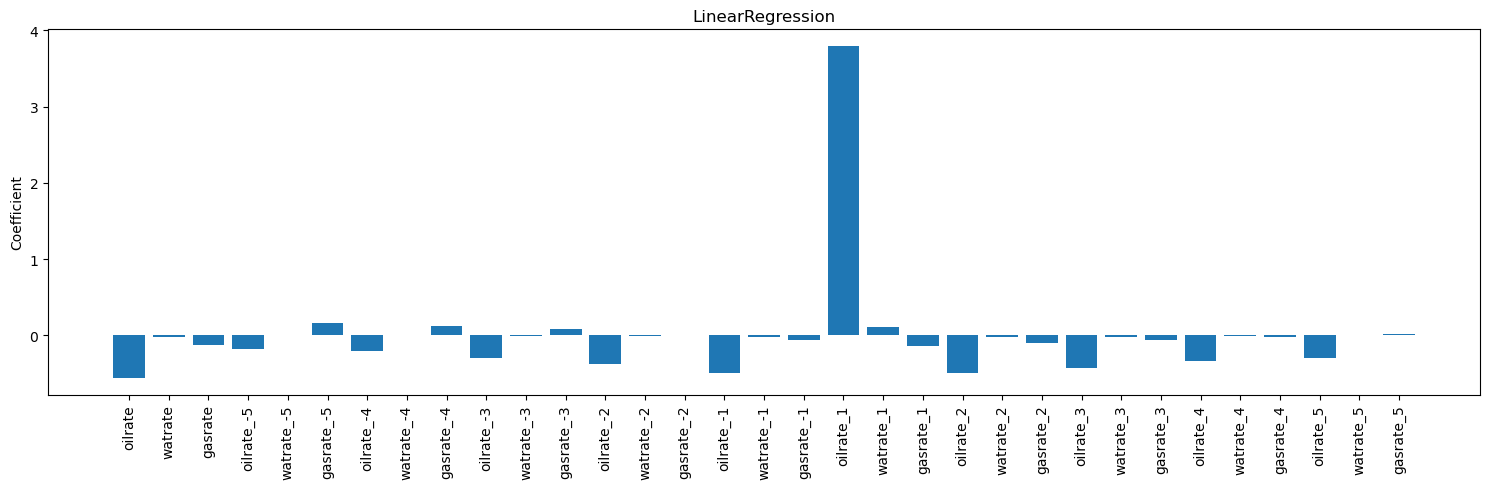

RidgeCV: RMSE=1.5030587219159053
intercept=1.5283160603401554e-14
alpha=93.26033468832199


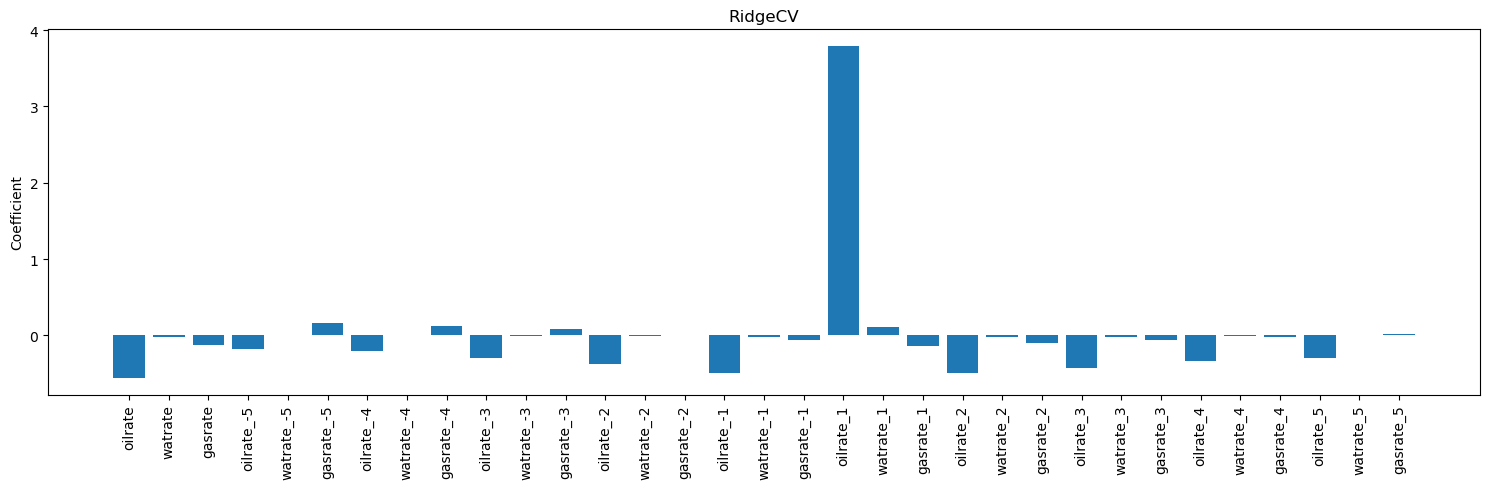

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler


def fit_regression(model, X_train, y_train, X_test, y_test):
    scaler = StandardScaler()
    columns = X_train.columns
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(X_train, y_train)
    score = rmse(y_test, model.predict(X_test))
    model_name = model.__class__.__name__
    print(f'{model_name}: RMSE={score}')
    print(f'intercept={model.intercept_}')
    if not isinstance(model, LinearRegression):
        print(f'alpha={model.alpha_}')
    plt.figure(figsize=(15, 5))
    plt.bar(columns, model.coef_)
    plt.xticks(rotation=90)
    plt.title(model_name)
    plt.ylabel('Coefficient')
    plt.tight_layout()
    plt.savefig(figures_folder / (model_name + '.png'))
    plt.show()


alphas = np.geomspace(1e-5, 1e5, 100)
linear_models = [LinearRegression(), RidgeCV(alphas=alphas)]

for model in linear_models:
    fit_regression(model, X_train, y_train, X_test, y_test)

# Tree and Random Forest

DecisionTreeRegressor RMSE=1.5191738973224251


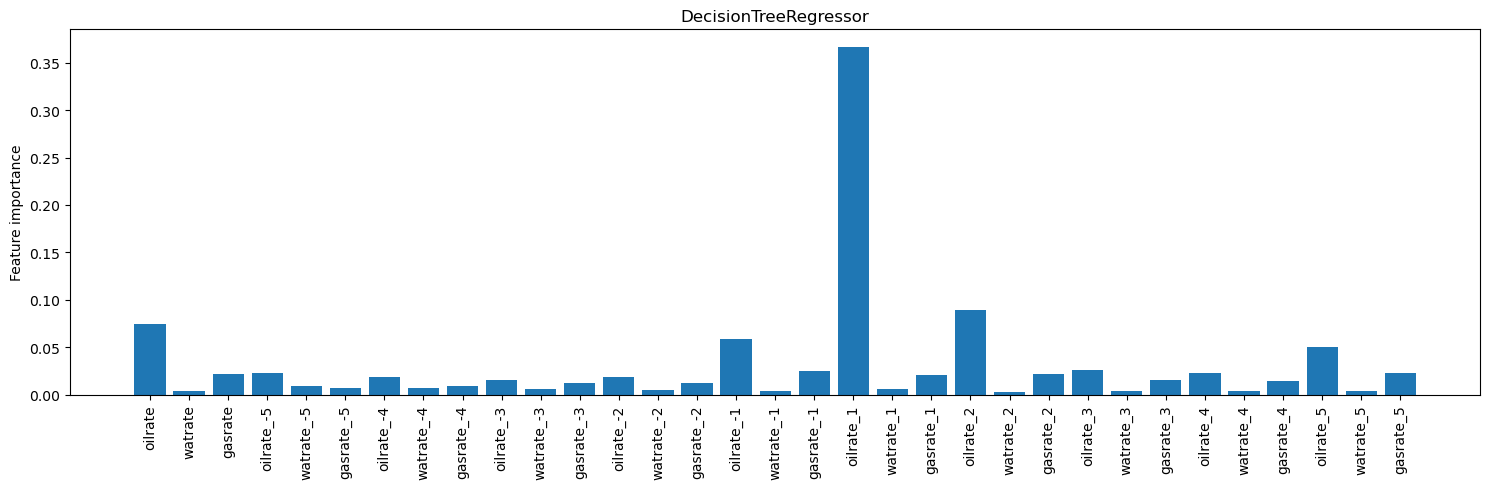

RandomForestRegressor RMSE=1.0782585199803159


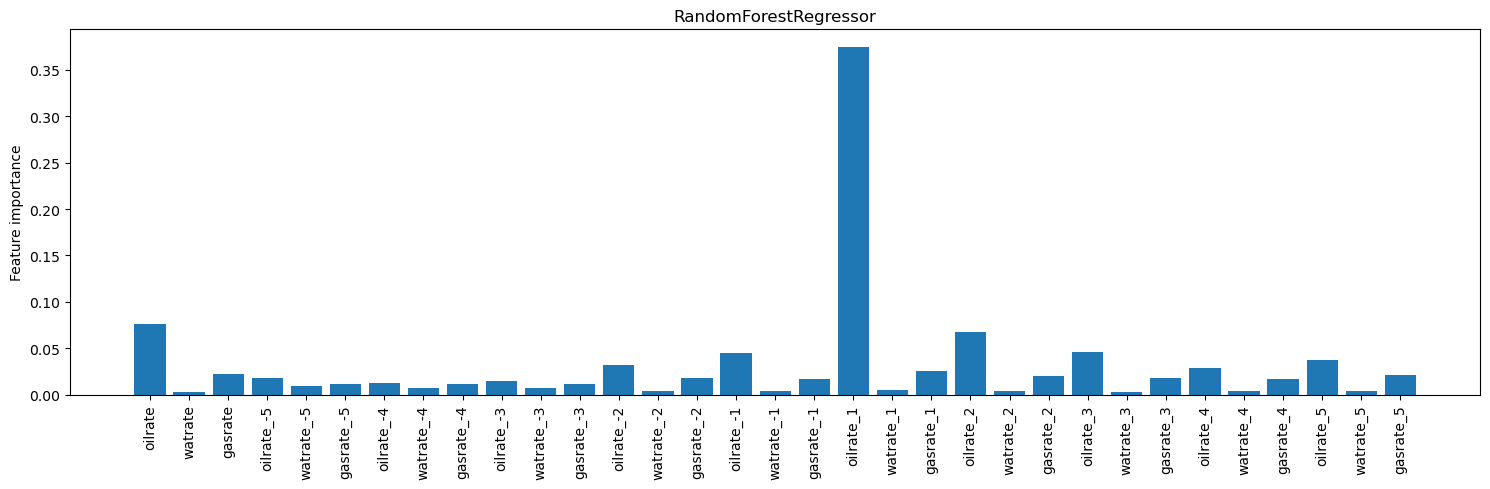

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

MAX_DEPTH = None

for model in [DecisionTreeRegressor(max_depth=MAX_DEPTH), RandomForestRegressor(n_estimators=10, max_depth=MAX_DEPTH)]:
    model.fit(X_train, y_train)
    score = rmse(y_test, model.predict(X_test))
    print(f'{model.__class__.__name__} RMSE={score}')
    plt.figure(figsize=(15, 5))
    plt.bar(X_train.columns, model.feature_importances_)
    plt.xticks(rotation=90)
    plt.title(model.__class__.__name__)
    plt.ylabel('Feature importance')
    plt.tight_layout()
    plt.savefig(figures_folder / f'{model.__class__.__name__}.png')
    plt.show()


# CatBoost

In [29]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=False)
model.fit(X_train, y_train)
score = rmse(y_test, model.predict(X_test))
print(f'RMSE={score}')

D:\anaconda3\envs\invest\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


RMSE=0.8116370391258605


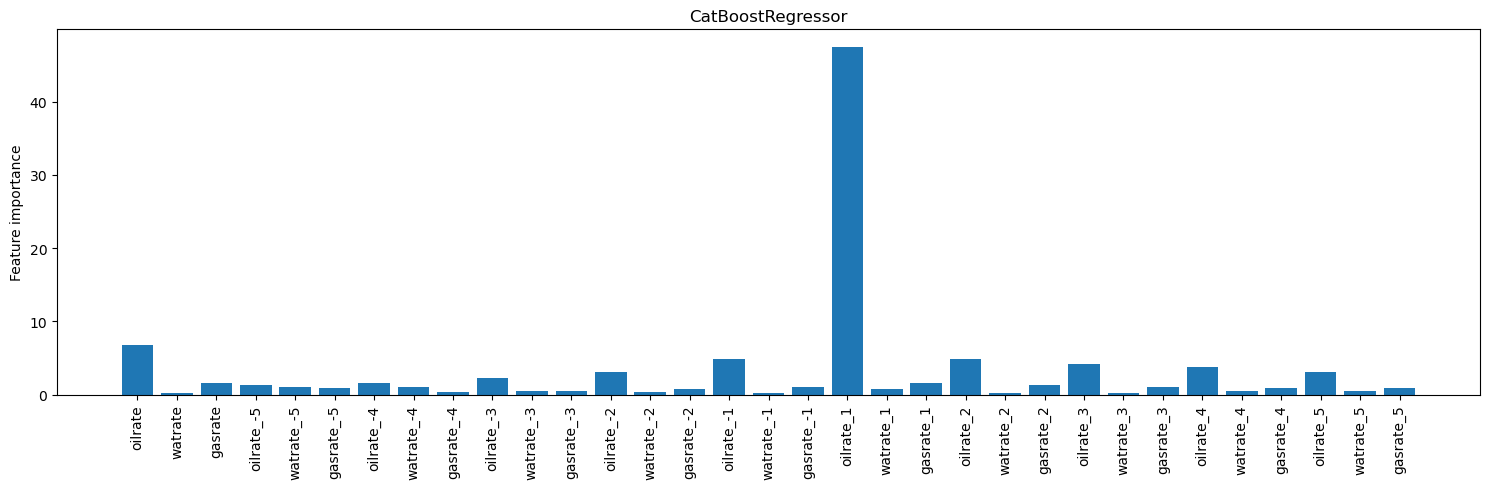

In [30]:
plt.figure(figsize=(15, 5))
plt.bar(X_train.columns, model.feature_importances_)
plt.xticks(rotation=90)
plt.title(model.__class__.__name__)
plt.ylabel('Feature importance')
plt.tight_layout()
plt.savefig(figures_folder / f'{model.__class__.__name__}.png')
plt.show()